In [1]:
import torch
import torchvision
from tqdm import tqdm
import torch.nn.functional as F
import random
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2
import sys
sys.path.append('../')
from data.FloorPlanLoader import *
from model.VQAE import VQAE
from utils import *
from train import *

#Reproducability Checks:
random.seed(0) #Python
torch.manual_seed(0) #Torch
np.random.seed(0) #NumPy

### Hyperparameters

In [2]:
#Hyperparameter
batch_size = 256
n_hiddens = 32
n_residual_hiddens = 32
n_residual_layers = 1
embedding_dim = 64
n_embeddings = 218
beta = .25
lr = 3e-3
noise=False
noise_weight=0.05
img_channel=3

### Load Dataset

In [3]:
#Load Dataset
floor = FloorPlanDataset(multi_scale=True, root='../data/data_root/data00/',\
                         data_config='../data/data_config/', preprocess=True)
data_variance = floor.var
val_len = int(len(floor)/10)
train_set, val_set = torch.utils.data.random_split(floor, [len(floor)-val_len, val_len])

print(f"data shape: {floor[0]['image_tensor'].shape}, dataset size: {len(floor)}, data variance: {data_variance}")

train_loader = torch.utils.data.DataLoader(train_set, batch_size = batch_size, shuffle = True)
validation_loader = torch.utils.data.DataLoader(val_set, batch_size = batch_size, shuffle = False)

data shape: torch.Size([3, 112, 112]), dataset size: 70597, data variance: 0.020686835050582886


In [4]:
floor.meta_info['AgeLabel'].describe()

count    1.048575e+06
mean     2.537797e-01
std      5.565936e-01
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      3.000000e+00
Name: AgeLabel, dtype: float64

### Load Best or Train

In [5]:
vqvae = VQAE(n_hiddens, n_residual_hiddens, n_residual_layers,
                n_embeddings, embedding_dim, 
                beta, img_channel).to(device)
optimizer = torch.optim.Adam(vqvae.parameters(), lr=lr, amsgrad=False)
train_res_recon_error = []
test_res_recon_error = []
start_epoch = 0
end_epoch = 300
best_loss = 2

##### load best checkpoint

In [13]:
vqvae.load_state_dict(torch.load("../best_checkpoint/final/55-vqae-0.04753296934928414.pt"))
optimizer.load_state_dict(torch.load("../best_checkpoint/final/55-adam-0.04753296934928414.pt"))

with open("../best_checkpoint/final/55-vqae_train-0.04753296934928414.json") as json_file:
    train_res_recon_error = json.load(json_file)
with open("../best_checkpoint/final/55-vqae_test-0.04753296934928414.json") as json_file:
    test_res_recon_error = json.load(json_file)
    
start_epoch = 55
end_epoch = 300
best_loss = 0.06130623703367973

##### train

In [ ]:
for epoch in range(start_epoch+1, end_epoch+1):
    with tqdm(train_loader, unit="batch") as tepoch:
        vqvae.train()
        for data_dict in tepoch:
            data = data_dict['image_tensor']
            data_no_noise = data.to(device)
            optimizer.zero_grad()

            if noise:
                data = add_noise(data_no_noise, noise_weight=noise_weight)
            else:
                data = data_no_noise
            vq_loss, data_recon, perplexity = vqvae(data)
            recon_error = F.mse_loss(data_recon, data) / data_variance
            loss = recon_error + vq_loss
            loss.backward()

            optimizer.step()
            tepoch.set_postfix(loss=float(loss.detach().cpu()))
            train_res_recon_error.append(recon_error.item())

    avg_loss = 0
    vqvae.eval()
    with torch.no_grad():
        for data_dict in validation_loader:
            data = data_dict['image_tensor']
            data = data.to(device)

            vq_loss, data_recon, perplexity = vqvae(data)
            recon_error = F.mse_loss(data_recon, data) / data_variance
            loss = recon_error.item() * batch_size

            avg_loss += loss / val_len
            test_res_recon_error.append(loss)
            
    if epoch%5==0 and avg_loss<best_loss:
        best_loss = avg_loss
        best_epoch = epoch
        torch.save(vqvae.state_dict(), f"../checkpoint/{best_epoch}-vqae-{best_loss}.pt")
        torch.save(optimizer.state_dict(), f"../checkpoint/{best_epoch}-adam-{best_loss}.pt")
        with open(f"../checkpoint/{best_epoch}-vqae_train-{best_loss}.json", 'w', encoding ='utf8') as json_file:
            json.dump(train_res_recon_error, json_file, ensure_ascii = False)
        with open(f"../checkpoint/{best_epoch}-vqae_test-{best_loss}.json", 'w', encoding ='utf8') as json_file:
            json.dump(test_res_recon_error, json_file, ensure_ascii = False)

    print(f'Validation Loss: {avg_loss}')

In [10]:
torch.save(vqvae.state_dict(), f"../checkpoint/{best_epoch}-vqae_final-{best_loss}.pt")
torch.save(optimizer.state_dict(), f"../checkpoint/{best_epoch}-adam_final-{best_loss}.pt")
with open(f"../checkpoint/{best_epoch}-vqae_train_final-{best_loss}.json", 'w', encoding ='utf8') as json_file:
    json.dump(train_res_recon_error, json_file, ensure_ascii = False)
with open(f"../checkpoint/{best_epoch}-vqae_test_final-{best_loss}.json", 'w', encoding ='utf8') as json_file:
    json.dump(test_res_recon_error, json_file, ensure_ascii = False)

### Visualization

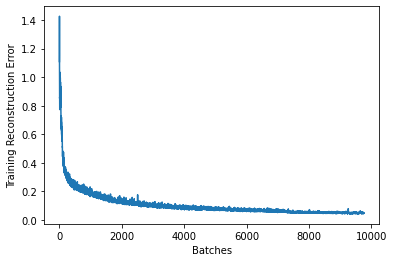

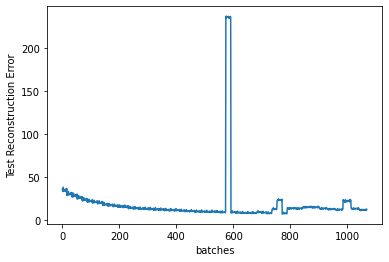

In [14]:
plt.plot(train_res_recon_error[20:])
plt.xlabel('Batches')
plt.ylabel('Training Reconstruction Error')
plt.show()

plt.plot(test_res_recon_error[20:])
plt.xlabel('batches')
plt.ylabel('Test Reconstruction Error')
plt.show()

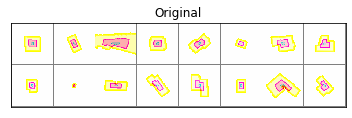

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


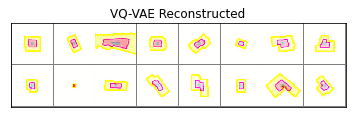

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


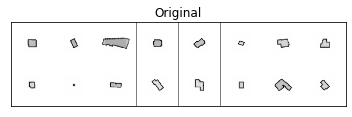

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


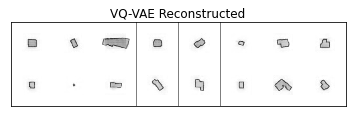

In [15]:
vqvae.eval()
temp_loader = torch.utils.data.DataLoader(val_set,batch_size=16,shuffle=True)
(valid_originals) = next(iter(temp_loader))
valid_originals = valid_originals['image_tensor'].to(device)

_, valid_recon, _ = vqvae(valid_originals)

def show(img, title):
    npimg = img.numpy()
    fig = plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)
    fig.axes.set_title(title)


show(torchvision.utils.make_grid(valid_originals.cpu()) + 0.5, "Original")
plt.show()
show(torchvision.utils.make_grid(valid_recon.cpu().data) + 0.5, "VQ-VAE Reconstructed")
plt.show()

def rescale_img(multi_scaled_channels): #B,C,H,W
    composed_1 = transforms.Resize(700)
    composed_2 = transforms.Compose([
                                    transforms.Resize(224),
                                    transforms.Pad(238, fill=1.0)])
    composed_3 = transforms.Pad(294, fill=1.0)
    composed_0 = transforms.Compose([transforms.Grayscale(),
                        transforms.CenterCrop(224)])
    
    channel_1 = composed_1(multi_scaled_channels[:,0:1,:,:])
    channel_2 = composed_2(multi_scaled_channels[:,1:2,:,:])
    channel_3 = composed_3(multi_scaled_channels[:,2:3,:,:])
    return composed_0(torch.cat([channel_1,channel_2,channel_3], dim=1))

valid_originals = rescale_img(valid_originals)
valid_recon = rescale_img(valid_recon)

show(torchvision.utils.make_grid(valid_originals.cpu())+0.5, "Original")
plt.show()
show(torchvision.utils.make_grid(valid_recon.cpu().data) + 0.5, "VQ-VAE Reconstructed")
plt.show()